# Модель машинного обучения для прогнозирования температуры сплавов для металлургического комбината

**Исходные данные** состоят из нескольких файлов, полученных из разных источников:
- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

***Цель проекта*** - построить модель, предсказывающую температуру сплава, для оптимизации производственных расходов посредством уменьшения потребления электроэнергии на этапе обработки стали. 

**План работы:**
1. Загрузка данных, исследовательский анализ и предобработка данных.
2. Объединение выделенных для последующего анализа признаков в единный датафрейм.
3. Статистический и графических анализ объединённого датафрейма, дополнительная предобработка при необходимости.
4. Корреляционный анализ признаков.
5. Подготовка данных для обучения модели. 
6. Обучение моделей машинного обучения и выбор лучшей модели.
7. Анализ важности признаков и анализ остатков.
8. Общий вывод и рекомендации.

In [1]:
! pip install -U scikit-learn -q
! pip install shap -q
! pip install phik -q
! pip install matplotlib==3.5.0 -q

In [2]:
# импортируем необходимые библиотеки:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# загружаем функцию для работы с метриками
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)
from sklearn.compose import ColumnTransformer
# импортируем класс:
from sklearn.model_selection import RandomizedSearchCV
# загружаем нужные модели и ансамбли
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
import catboost
from catboost import CatBoostRegressor

import shap

import warnings 
warnings.filterwarnings('ignore')

## Подготовка данных

### Первичное исследование данных

Общие сведения об имеющих данных: состав данных, наличие пропусков и дубликатов.

In [3]:
files = ['data_arc_new.csv', 'data_bulk_new.csv', 'data_bulk_time_new.csv', 'data_gas_new.csv', 'data_temp_new.csv', 'data_wire_new.csv', 
         'data_wire_time_new.csv'] 
for i in files:
    try:
        print (i)
        file = pd.read_csv ('/datasets/' + i)
        display(file.head(10))
        print ('Кол-во дубликатов:', file.duplicated().sum())
        file.info()
        print ()
    except:
        print (f'Данные {i} не загружены')

data_arc_new.csv


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Кол-во дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

data_bulk_new.csv


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Кол-во дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

data_bulk_time_new.csv


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


Кол-во дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB

data_gas_new.csv


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Кол-во дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

data_temp_new.csv


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Кол-во дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB

data_wire_new.csv


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Кол-во дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

data_wire_time_new.csv


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Кол-во дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB



   Файл `data_arc_new.csv` содержит сведения об электродах: номер партии, время начала и окончания нагрева, значения активной и реактивной мощности - всего 5 столбцов и 14876 строк без пропусков и дубликатов. При этом номер партии повторяется в нескольких строках, а время начала и окончания нагрева имеет строковый тип данных, хотя по содержанию больше подходит временной тип данных. Исправим это. А также добавим столбец с информацией о длительности нагрева в секундах.

In [4]:
arc = pd.read_csv ('/datasets/data_arc_new.csv')
# изменим тип данных:
arc [['Начало нагрева дугой', 'Конец нагрева дугой']] = arc [['Начало нагрева дугой', 'Конец нагрева дугой']].astype('datetime64[ns]')
# добавим столбец с информацией о длительности нагрева, установив тип данных float:
arc ['Длительность нагрева, сек'] = arc ['Конец нагрева дугой'] - arc ['Начало нагрева дугой']
arc ['Длительность нагрева, сек'] = arc ['Длительность нагрева, сек'].dt.total_seconds().div(60).round(2)
# добавим столбец с информацией об общей мощности нагрева в партии:
arc ['Мощность нагрева'] = np.sqrt(arc ['Активная мощность']**2 + arc ['Реактивная мощность']**2)
arc ['Количество нагревов'] = 1
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Длительность нагрева, сек",Мощность нагрева,Количество нагревов
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,3.80,0.371123,1
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,3.08,0.902319,1
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,2.87,0.722536,1
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,6.08,0.642824,1
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,2.47,1.079934,1


In [5]:
len(arc ['key'].unique())

3214

Всего в данных об электродах содержится информация о нагревах по 3214 партиям. Некоторые партии подвергались нагреву несколько раз, сгруппируем информацию по  партиям агригировав все нагревы:

In [6]:
#удалим столбцы с датами и составляющиe общей мощности: 
arc = arc.drop(columns=['Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность'])

In [7]:
#агрегируем данные оставшихся столбцов
arc = pd.pivot_table (arc, index=['key'], aggfunc=np.sum)
arc = arc.reset_index()
arc.head() 

,key,"Длительность нагрева, сек",Количество нагревов,Мощность нагрева
0,1,18.30,5,3.718736
1,2,13.51,4,2.588349
2,3,10.92,5,5.019223
3,4,12.35,4,3.400038
4,5,14.48,4,2.816980


В итоговой таблице с информацией о нагревах из имеющихся исходных данных выделены 3 признака - суммарная длительность нагрева, количество нагревов и суммарная мощность по партиям. 

Файлы `data_bulk_new.csv` и `data_bulk_time_new.csv` содержат сведения о подаче сыпучих материалов (объём и время подачи): номер партии - объём подаваемого материала и номер партии - время подачи материала. Каждый из файлов состоит из 16 признаков, первый из которых - это номер партии, а остальные соответственно - объем или время подачи. Всего 3129 строк. Данные не содержат дубликатов, но содержат много пропусков. Исходя из данных обоих файлов, которые содержат идентичные пропуски, пропуски в данном случае вероятно означают отсутствие подачи сыпучих материалов. Для последующего анализа на основе данных файлов сгенерируем 2 признака - количество подач сыпучих материалов и их общий объем.

In [8]:
bulk = pd.read_csv ('/datasets/data_bulk_new.csv')
bulk ['Объем сып.мат.'] = bulk.sum(axis=1) - bulk ['key']
# минус 1, чтобы в количество не вошел признак номера партии
bulk ['Количество подач сып.мат.'] = bulk.count(axis=1) - 1
# удалим лишние столбцы
bulk = bulk [['key', 'Объем сып.мат.', 'Количество подач сып.мат.']]
bulk.head()

,key,Объем сып.мат.,Количество подач сып.мат.
0,1,553.0,5
1,2,582.0,5
2,3,544.0,5
3,4,595.0,5
4,5,584.0,5


In [9]:
len(bulk ['key'].unique())

3129

Значения в столбце с информацией о номере партии в данном датафрейме не повторяются.

Файл `data_gas_new.csv` содержит сведения о продувке сплава газом: номер партии и объём подаваемого газа - всего 2 признака и 3239 строк без пропусков и дубликатов в подходящем формате данных.

In [10]:
gas = pd.read_csv ('/datasets/data_gas_new.csv')
len(gas ['key'].unique())

3239

Значения в столбце с информацией о номере партии в данном датафрейме также не повторяются.

Файл `data_temp_new.csv` содержит сведения о результатах измерения температуры: номер партии, время замера и значение температуры - всего 3 признака и 18092 строк без дубликатов, но с пропусками значений температуры. Замеры температуры производились несколько раз по 1 партии. 

In [11]:
temp = pd.read_csv ('/datasets/data_temp_new.csv')
#посчитаем количество уникальных значений в столбце с информацией о номере партии:
len(temp ['key'].unique())

3216

In [12]:
#удаляем пропуски в данных
temp = temp.dropna()

In [13]:
# посчитаем количество измерений температур по партиям:
temp_count = temp ['key'].value_counts()
# выделим партии с 1 измерением температуры в партии:
temp_1 = temp_count[temp_count==1]
temp_1.index

Int64Index([2566, 2913, 3121, 2550, 2558, 3032, 2976, 3113, 3024, 3097,
            ...
            3204, 2971, 3212, 3220, 3228, 3236, 2963, 2955, 2947, 2525],
           dtype='int64', length=741)

741 партия имеет по 1 замеру температуры - по ним отсутствует информация о конечной достигнутой температуре и, соответственно, они не будут полезны при моделировании и могут быть исключены из данных для последующего анализа:

In [14]:
temp = temp[~(temp['key'].isin(temp_1.index))]

In [15]:
#считаем количество уникальных значений в столбце с информацией о номере партии после удаления пропусков:
len(temp ['key'].unique())

2475

После удаления неинформативных партий оставшийся объем данных содержит сведения о 2 и более значениях температуры по 2475 партиям.

Первый замер температуры - это исходный признак, над которым производились последующие действия для достижения необходимого результата, значение последнего замера - достигнутый результат (для разных партий при этом произведено разное количество замеров, что может быть связано с количеством произведенных действий с данной партией). Таким образом, для дальнейшего исследования выделим два признака данного датафрейма: входной признак - значение первого замера и целевой признак - значение последнего замера.

In [16]:
#переведем значения в столбце со значениями времени замеров в формат времени
temp['Время замера'] = temp['Время замера'].astype('datetime64[ns]')
#отсортируем по времени измерения температуры
temp = temp.sort_values(by=['key', 'Время замера'])
#сгенерируем признаки
temp = pd.pivot_table (temp, index=['key'], values = ['Температура'], aggfunc=('first','last'))
#переименуем столбцы 
temp.columns = ['Первичная температура', 'Итоговая температура']
temp = temp.reset_index()
temp.sample(5)

,key,Первичная температура,Итоговая температура
658,669,1589.0,1595.0
2194,2213,1590.0,1599.0
505,513,1558.0,1589.0
2263,2283,1594.0,1591.0
471,478,1616.0,1590.0


In [17]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2475 non-null   int64  
 1   Первичная температура  2475 non-null   float64
 2   Итоговая температура   2475 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.1 KB


В итоговой таблице об измерениях температуры выделены признаки со значениями первичной и итоговой температур по 2475
партиям.

Файлы `data_wire_new.csv` и `data_wire_time_new.csv` содержат сведения о подаче проволочных материалах (объём и время подачи): номер партии - объём подаваемого материала и номер партии - время подачи материала. Каждый из файлов состоит из 10 признаков, первый из которых - это номер партии, а остальные соответственно - объем или время подачи. Всего 3081 строка. Данные не содержат дубликатов, но содержат много пропусков. Исходя из данных обоих файлов, которые содержат идентичные пропуски, пропуски в данном случае вероятно означают отсутствие подачи проволочных материалов. Для последующего анализа на основе данных файлов по аналогии с сыпучими материалами сгенерируем 2 признака - количество подач проволочных материалов и их общий объем.

In [18]:
wire = pd.read_csv ('/datasets/data_wire_new.csv')
wire ['Объем провол.мат.'] = wire.sum(axis=1) - wire ['key']
# минус 1, чтобы в количество не вошел признак номера партии
wire ['Количество подач провол.мат.'] = wire.count(axis=1) - 1
# удалим лишние столбцы
wire = wire [['key', 'Объем провол.мат.', 'Количество подач провол.мат.']]
wire.head()

,key,Объем провол.мат.,Количество подач провол.мат.
0,1,60.059998,2
1,2,96.052315,2
2,3,91.160157,2
3,4,89.063515,2
4,5,98.352796,3


In [19]:
len(wire ['key'].unique())

3081

Значения в столбце с информацией о номере партии в данном датафрейме не повторяются.

В ходе первичного исследования данных из 7 файлов с исходными данными получены 5 новых датасетов 
(arc - информация о нагревах,  bulk - информация о сыпучих материалах, gas - сведения о продувке газом (оставлен без изменений), temp - сведения о замерах температуры, wire -  информация о проволочных материалах) с выбранными либо сгенерированными на исходных данных входными признаками, а также выделен целевой признак (Итоговая температура). В следующих подразделах объединим данные в единный датафрейм и проведем статистический и графический анализ признаков.

### Объединение данных

Объединение данных проведем по номеру партию (key), за основу объединения возьмем датасет с целевым признаком (temp). В объединеный датасет включим партии, информация о которых присутствует во всех датасетах, в целях более полного отражения признаков.

In [20]:
for i in [arc, bulk, wire, gas]:
    temp = temp.merge (i, on='key', how='inner')
temp.head()

,key,Первичная температура,Итоговая температура,"Длительность нагрева, сек",Количество нагревов,Мощность нагрева,Объем сып.мат.,Количество подач сып.мат.,Объем провол.мат.,Количество подач провол.мат.,Газ 1
0,1,1571.0,1613.0,18.30,5,3.718736,553.0,5,60.059998,2,29.749986
1,2,1581.0,1602.0,13.51,4,2.588349,582.0,5,96.052315,2,12.555561
2,3,1596.0,1599.0,10.92,5,5.019223,544.0,5,91.160157,2,28.554793
3,4,1601.0,1625.0,12.35,4,3.400038,595.0,5,89.063515,2,18.841219
4,5,1576.0,1602.0,14.48,4,2.816980,584.0,5,98.352796,3,5.413692


In [21]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   key                           2329 non-null   int64  
 1   Первичная температура         2329 non-null   float64
 2   Итоговая температура          2329 non-null   float64
 3   Длительность нагрева, сек     2329 non-null   float64
 4   Количество нагревов           2329 non-null   int64  
 5   Мощность нагрева              2329 non-null   float64
 6   Объем сып.мат.                2329 non-null   float64
 7   Количество подач сып.мат.     2329 non-null   int64  
 8   Объем провол.мат.             2329 non-null   float64
 9   Количество подач провол.мат.  2329 non-null   int64  
 10  Газ 1                         2329 non-null   float64
dtypes: float64(7), int64(4)
memory usage: 218.3 KB


Объединенный датафрейм содержит 10 признаков по 2329 партиям.

## Статистический и графический анализ данных

In [22]:
#переместим номер партиии в индекс
temp = temp.set_index('key')

**Статистическое описание данных.**

In [23]:
temp.describe()

,Первичная температура,Итоговая температура,"Длительность нагрева, сек",Количество нагревов,Мощность нагрева,Объем сып.мат.,Количество подач сып.мат.,Объем провол.мат.,Количество подач провол.мат.,Газ 1
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1586.718763,1593.365393,13.460696,4.695578,4.191859,609.630313,4.592958,125.208530,2.397166,11.375600
std,28.290792,11.200915,5.680390,1.606629,14.873681,287.599678,1.224416,63.683386,0.564416,6.392041
min,1191.000000,1541.000000,0.950000,1.000000,0.331897,19.000000,2.000000,1.918800,2.000000,0.008399
25%,1571.000000,1587.000000,9.680000,4.000000,2.844193,440.000000,4.000000,89.013596,2.000000,7.282948
50%,1587.000000,1593.000000,12.970000,5.000000,3.769823,609.000000,5.000000,116.101440,2.000000,10.100950
75%,1603.000000,1598.000000,16.550000,6.000000,4.770751,795.000000,5.000000,151.568558,3.000000,14.216688
max,1660.000000,1653.000000,69.820000,16.000000,717.937368,3235.000000,8.000000,568.777664,6.000000,77.995040


**Графическое описание данных.**

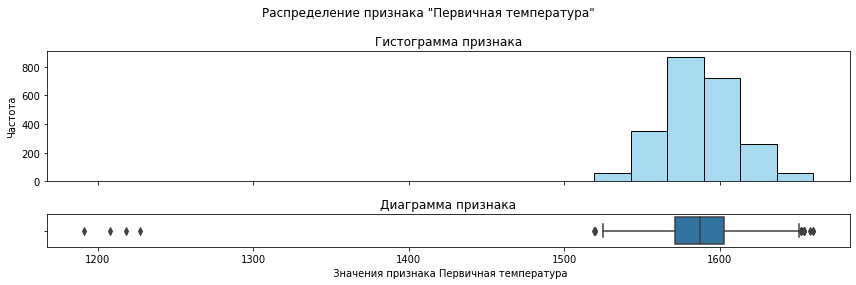

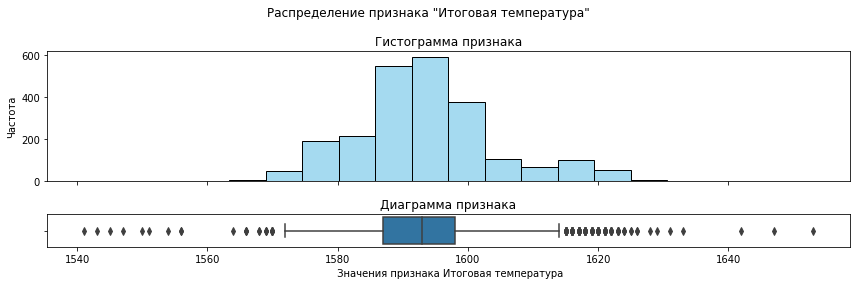

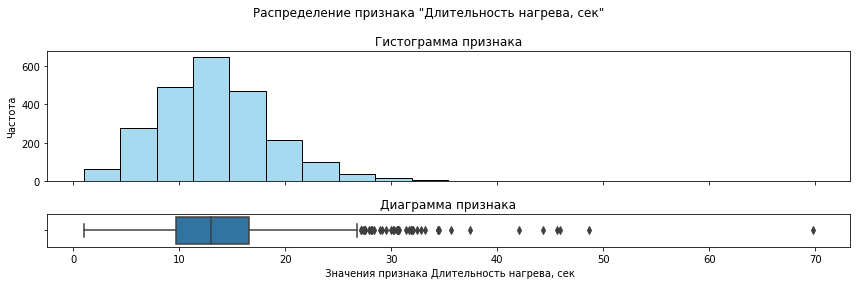

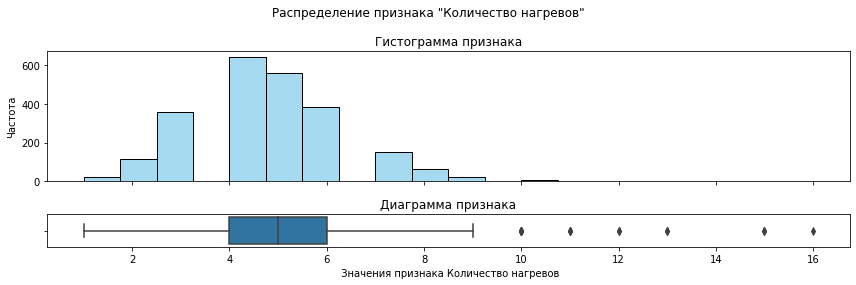

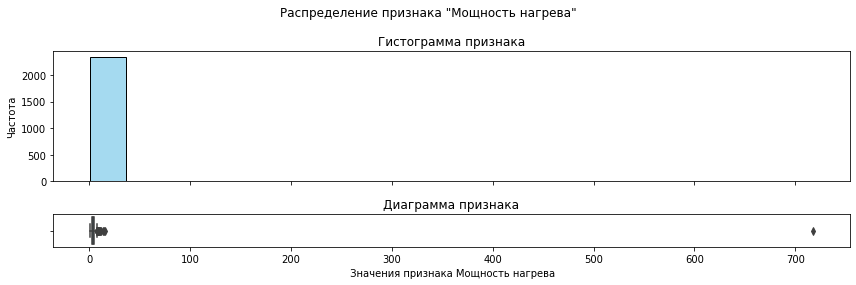

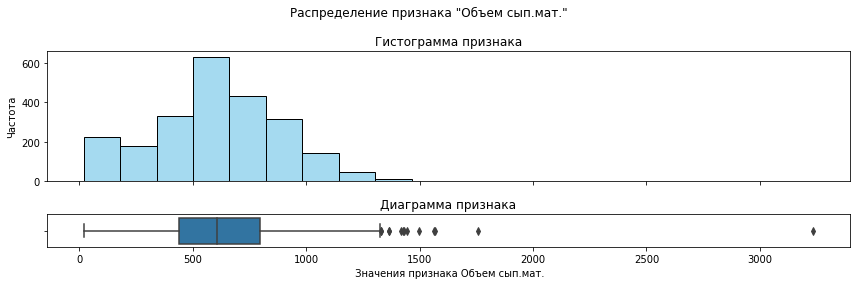

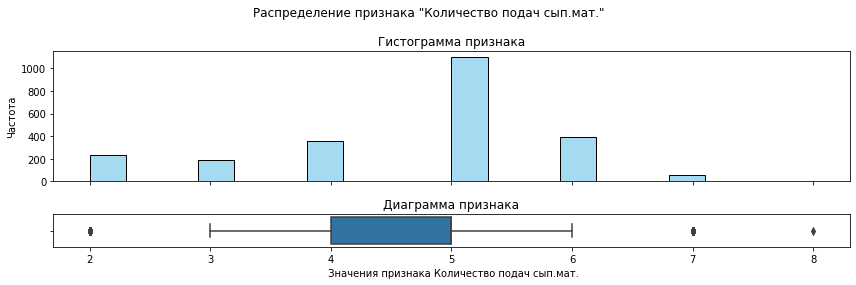

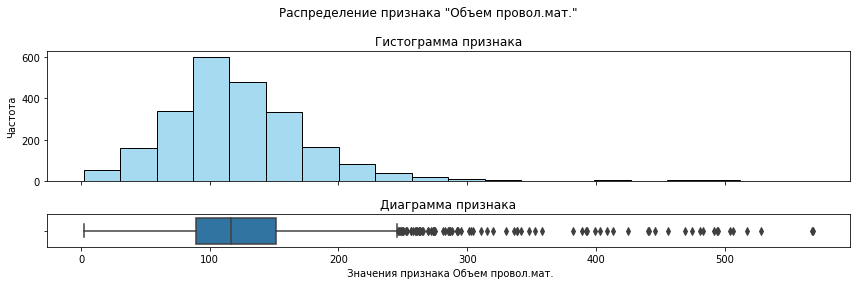

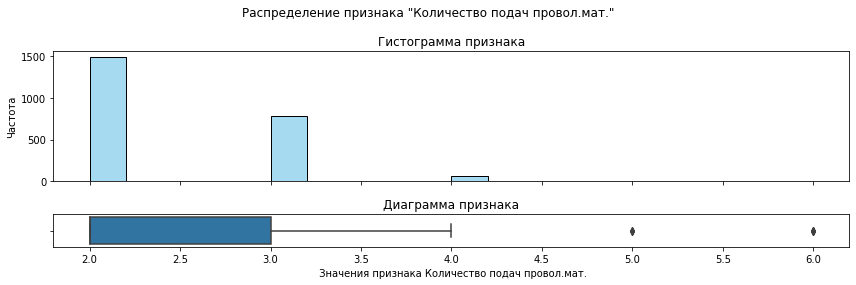

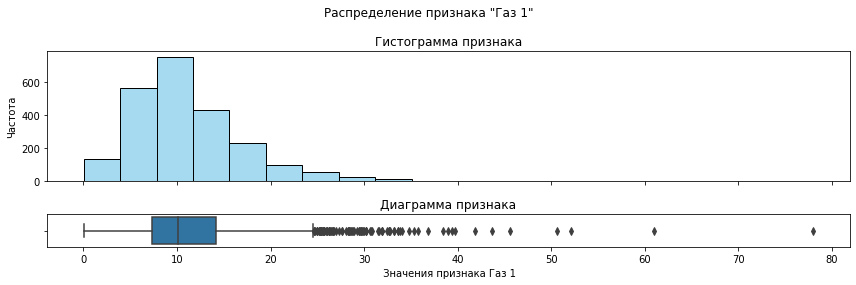

In [24]:
for i in temp.columns:
    # cоздаем фигуру и оси с разными пропорциями высоты
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 4), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)
    plt.suptitle(f'Распределение признака "{i}"')
    # построение гистограммы
    sns.histplot(temp[i], bins=20, ax=ax1, kde=False, color='skyblue')
    ax1.set_title(f'Гистограмма признака')
    ax1.set_ylabel('Частота')
    # построение диаграммы размаха с Seaborn
    sns.boxplot(x=temp[i], ax=ax2)
    ax2.set_title(f'Диаграмма признака')
    ax2.set_xlabel(f' Значения признака {i}')
    # отображение графиков
    plt.tight_layout()
    plt.show()
    print();

Значения **признаков температуры** (первичная и итоговая) имеют показатели от 1191 до 1660, медианные значения равны 1587-1593 и схожи со средними. При этом на графиках признака "Первичная температура" наблюдаются явные выбросы значений - значения ниже температуры плавления стали (ок. 1400).

In [25]:
temp[temp['Первичная температура'] <= 1400]

,Первичная температура,Итоговая температура,"Длительность нагрева, сек",Количество нагревов,Мощность нагрева,Объем сып.мат.,Количество подач сып.мат.,Объем провол.мат.,Количество подач провол.мат.,Газ 1
key,,,,,,,,,,
867,1191.0,1599.0,16.14,7,6.044517,691.0,5,193.587684,3,11.616807
1214,1208.0,1591.0,8.01,3,2.523002,431.0,4,53.118000,2,12.933558
1619,1218.0,1590.0,4.10,2,1.245024,45.0,2,200.321678,3,4.542025
2052,1227.0,1592.0,10.54,5,3.692965,494.0,5,116.014076,2,8.639928


Исключим данные партии из датасета:

In [26]:
temp = temp[temp['Первичная температура'] > 1400]
print (f'Размер данных: {temp.shape}')

Размер данных: (2325, 10)


Признак **длительности нагрева** имеет значения от 0.95  до 69.82 секунд с медианным значением = 12.97 секунд и средним значением =13.46 сек. В основном значения распределены нормально, но присутствуют и аномалии:

In [27]:
temp[temp['Длительность нагрева, сек'] >= 40]

,Первичная температура,Итоговая температура,"Длительность нагрева, сек",Количество нагревов,Мощность нагрева,Объем сып.мат.,Количество подач сып.мат.,Объем провол.мат.,Количество подач провол.мат.,Газ 1
key,,,,,,,,,,
46,1607.0,1612.0,48.64,13,11.591736,879.0,5,100.245593,2,6.118441
322,1619.0,1616.0,44.30,13,11.075555,3235.0,7,188.228550,2,77.995040
1513,1553.0,1574.0,42.10,15,14.466533,881.0,7,190.427115,3,38.471706
1689,1583.0,1606.0,69.82,15,15.288271,1757.0,6,187.153206,2,33.597044
1880,1606.0,1615.0,45.92,11,7.484913,1325.0,7,70.199997,2,26.379596
2108,1639.0,1541.0,45.67,16,13.134871,1004.0,6,260.934349,6,45.638999


Высокое значение длительности нагревов связано также с высоким показателем количества нагревов. 

Признак **количества нагревов** имеет значения от 1 до 16 с медианным знначением = 5 и средним значением = 4.7. Присутствуют и выбивающиеся высокие показатели:

In [28]:
temp[temp['Количество нагревов'] > 10]

,Первичная температура,Итоговая температура,"Длительность нагрева, сек",Количество нагревов,Мощность нагрева,Объем сып.мат.,Количество подач сып.мат.,Объем провол.мат.,Количество подач провол.мат.,Газ 1
key,,,,,,,,,,
44,1600.0,1603.0,34.39,12,8.981145,881.0,6,69.189123,2,21.265271
46,1607.0,1612.0,48.64,13,11.591736,879.0,5,100.245593,2,6.118441
322,1619.0,1616.0,44.30,13,11.075555,3235.0,7,188.228550,2,77.995040
638,1588.0,1619.0,34.46,11,8.817556,959.0,5,169.322388,2,19.798236
1513,1553.0,1574.0,42.10,15,14.466533,881.0,7,190.427115,3,38.471706
1689,1583.0,1606.0,69.82,15,15.288271,1757.0,6,187.153206,2,33.597044
1829,1535.0,1590.0,25.08,12,10.918670,963.0,5,36.082798,2,3.785225
1880,1606.0,1615.0,45.92,11,7.484913,1325.0,7,70.199997,2,26.379596
1958,1579.0,1570.0,30.56,11,8.811874,898.0,6,274.375926,4,32.449632


Которым также характерны высокие показатели длительности нагрева.

Показатель **мощности нагрева** принимает значения от 0.33 до 717.94 с медианным значением = 3.77 и средним значением = 4.19. Описательная статистика и графики показывают явные выбросы значений - значения, значительно превышающие среднее и медианное значения (более, чем в 100  раз) при стандартном отклонении = 15.

In [29]:
temp[temp['Мощность нагрева'] >= 100]

,Первичная температура,Итоговая температура,"Длительность нагрева, сек",Количество нагревов,Мощность нагрева,Объем сып.мат.,Количество подач сып.мат.,Объем провол.мат.,Количество подач провол.мат.,Газ 1
key,,,,,,,,,,
2116,1579.0,1578.0,7.22,4,717.937368,335.0,3,75.216965,2,11.582547


Исключим данную аномалию из датасета:

In [30]:
temp = temp[temp['Мощность нагрева'] < 100]
temp.shape

(2324, 10)

count    2324.000000
mean        3.886143
std         1.517584
min         0.331897
25%         2.846893
50%         3.770584
75%         4.769753
max        15.288271
Name: Мощность нагрева, dtype: float64


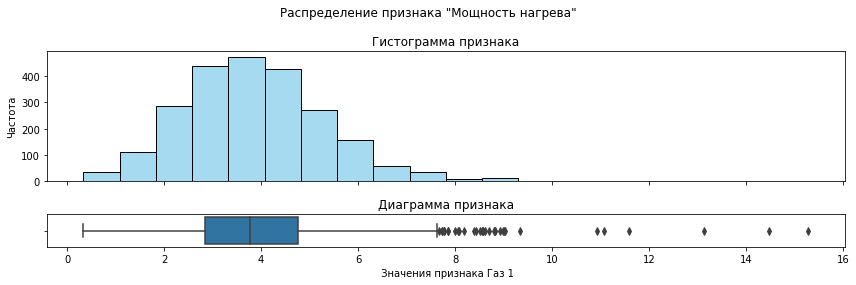

In [31]:
print(temp['Мощность нагрева'].describe())
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 4), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)
plt.suptitle(f'Распределение признака "Мощность нагрева"')
sns.histplot(temp['Мощность нагрева'], bins=20, ax=ax1, kde=False, color='skyblue')
ax1.set_title(f'Гистограмма признака')
ax1.set_ylabel('Частота')
sns.boxplot(x=temp['Мощность нагрева'], ax=ax2)
ax2.set_title(f'Диаграмма признака')
ax2.set_xlabel(f' Значения признака {i}')
plt.tight_layout()
plt.show()

После удаления выброса значения признака мощности нагрева приобрели в основном нормальное распределение с небольшим количеством аномальных значений:

In [32]:
temp[temp['Мощность нагрева'] >= 10]

,Первичная температура,Итоговая температура,"Длительность нагрева, сек",Количество нагревов,Мощность нагрева,Объем сып.мат.,Количество подач сып.мат.,Объем провол.мат.,Количество подач провол.мат.,Газ 1
key,,,,,,,,,,
46,1607.0,1612.0,48.64,13,11.591736,879.0,5,100.245593,2,6.118441
322,1619.0,1616.0,44.30,13,11.075555,3235.0,7,188.228550,2,77.995040
1513,1553.0,1574.0,42.10,15,14.466533,881.0,7,190.427115,3,38.471706
1689,1583.0,1606.0,69.82,15,15.288271,1757.0,6,187.153206,2,33.597044
1829,1535.0,1590.0,25.08,12,10.918670,963.0,5,36.082798,2,3.785225
2108,1639.0,1541.0,45.67,16,13.134871,1004.0,6,260.934349,6,45.638999


Которые можно объяснить также высокими показателями длительности и количества ннагревов.

Показатель **объема сыпучих материалов** принимает значения от 19 до 3235 с медианным значением = 609 и схожим средним значением. Описательная статистика и графики показывают значительные аномалии значений - значения, превышающие среднее и медианное значения в 2.5 и более раз:

In [33]:
temp[temp['Объем сып.мат.'] >= 1500]

,Первичная температура,Итоговая температура,"Длительность нагрева, сек",Количество нагревов,Мощность нагрева,Объем сып.мат.,Количество подач сып.мат.,Объем провол.мат.,Количество подач провол.мат.,Газ 1
key,,,,,,,,,,
322,1619.0,1616.0,44.30,13,11.075555,3235.0,7,188.228550,2,77.995040
327,1572.0,1586.0,20.94,6,7.154065,1569.0,6,97.016404,2,4.898431
1689,1583.0,1606.0,69.82,15,15.288271,1757.0,6,187.153206,2,33.597044
1999,1650.0,1613.0,11.74,5,4.598665,1563.0,5,100.070877,2,7.815190


Данные партии также имеют высокие показатели количества подачи сыпучих материалов. Допустим, что при каждой подаче использовалось максимально возможно количество сыпучих материалов и оставим данные аномалии для дальнейшего анализа.

Показатель **количества подачи сыпучих материалов** принимает значение от 2 до 8 с медианным значением = 5 и схожим средним значением, выбивающиееся аномалии не наблюдаются.

Показатель **объема проволочных материалов** принимает значения от 1.92 до 568.78 с медианным значением = 116.10 и средним значением = 125.21. Графики показывают, что значения признака в основном распределены нормально, с небольшим количеством незначительных аномалий:

In [34]:
temp[temp['Объем провол.мат.'] >= 500]

,Первичная температура,Итоговая температура,"Длительность нагрева, сек",Количество нагревов,Мощность нагрева,Объем сып.мат.,Количество подач сып.мат.,Объем провол.мат.,Количество подач провол.мат.,Газ 1
key,,,,,,,,,,
407,1554.0,1589.0,16.22,5,3.317154,359.0,3,517.560783,4,16.194449
988,1608.0,1587.0,13.49,5,4.480755,387.0,5,528.202918,4,19.279323
1840,1602.0,1589.0,9.59,4,3.761492,122.0,2,568.777664,4,13.767550
1841,1559.0,1589.0,15.66,6,6.087450,169.0,2,504.331137,4,13.814996
1915,1574.0,1586.0,16.89,8,6.020171,275.0,3,568.237950,4,12.918119
1916,1614.0,1590.0,9.89,5,5.406926,231.0,3,506.304676,4,18.867788


Данные партии также имеют значение признака количества подачи проволочных материалов выше среднего значения (4 при среднем = 2.4).

Признак **количества подач проволочных материалов** имеет значения от 2 до 6 с медианным знначением = 2 и схожим средним значением = 2.4, сильно выбивающиееся аномалии не наблюдаются.

Признак **объёма подаваемого газа** принимает значения от 0.01 до 78 с медианным знначением = 10.1 и средним значением = 11.4. Присутствуют и выбивающиеся высокие показатели:

In [35]:
temp[temp['Газ 1'] >= 40]

,Первичная температура,Итоговая температура,"Длительность нагрева, сек",Количество нагревов,Мощность нагрева,Объем сып.мат.,Количество подач сып.мат.,Объем провол.мат.,Количество подач провол.мат.,Газ 1
key,,,,,,,,,,
117,1625.0,1604.0,13.39,6,5.102765,557.0,5,120.044500,3,50.581035
280,1532.0,1600.0,30.13,9,5.191116,560.0,5,282.413042,4,60.935689
322,1619.0,1616.0,44.30,13,11.075555,3235.0,7,188.228550,2,77.995040
663,1593.0,1620.0,27.55,8,5.283477,1170.0,7,130.244400,2,41.854643
1464,1567.0,1585.0,19.95,4,2.002527,1316.0,6,280.987214,2,43.655411
2108,1639.0,1541.0,45.67,16,13.134871,1004.0,6,260.934349,6,45.638999
2110,1645.0,1551.0,9.12,5,2.429767,930.0,6,244.007932,6,52.142373


Данные партии также имеют высокие показатели количества подачи материалов, что может объяснять и высокие объемы подаваемого газа для продува сплава в партиях.

In [36]:
temp.shape

(2324, 10)

**Итог:** в ходе предобработки удалены 4 выброса в значениях температур (ниже температуры плавления стали) и 1 выброс в значениях мощности нагрева (значение, более чем в 100 раз превышающее средний показатель). Выборка после удаления выбросов содержит информацию по 2324 партиям.

## Корреляционный анализ признаков

interval columns not set, guessing: ['Первичная температура', 'Итоговая температура', 'Длительность нагрева, сек', 'Количество нагревов', 'Мощность нагрева', 'Объем сып.мат.', 'Количество подач сып.мат.', 'Объем провол.мат.', 'Количество подач провол.мат.', 'Газ 1']


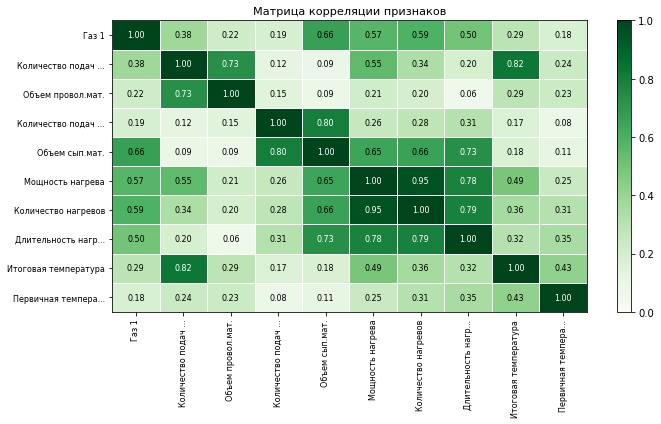

In [37]:
# посмотрим на матрицу корреляции на графике
phik_overview = phik_matrix(temp)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции признаков',
    fontsize_factor=0.8,
    figsize=(10, 6)
);

Мультиколлинеарность (значения коэффициентов корреляции от 0.9 до 1.0 по модулю) входных признаков наблюдается у признаков "Количество нагревов" и "Мощность нагрева", при этом с целевым признаком выше корреляция у признака "Мощность нагрева" (0.49 против 0.36 у признака "Количество нагревов"). Удалим признак с наименьшей корреляцией с целевым признаком ("Количество нагревов") из датасета перед обучением модели. 

In [38]:
temp = temp.drop('Количество нагревов', axis = 1)

In [39]:
print(f'Размер выборки составляет: {temp.shape[1]} признаков по {temp.shape[0]} партиям')

Размер выборки составляет: 9 признаков по 2324 партиям


Согласно матрице корреляции на целевой признак "Итоговая температура" наибольшее влияние оказывает входной признак "Количество подач проволочного материала" (коэффициент корреляции = 0.82), значительное влияние также оказывают признаки "Мощность нагрева" (коэффициент корреляции = 0.49) и "Первичная температура" (коэффициент корреляции = 0.43), самое слабое же влияние с коэффициентами корреляции 0.17 и 0.18 имеют признаки "Количество подач сыпучих материалов" и "Объем сыпучих материалов" соответственно.

## Машинное обучение

### Подготовка данных для обучения модели

Выделим целевой признак и разделим данные на обучающую и тестовую выборки в пропорции 3:1:

In [40]:
# выделим из тренировочной и тестовой входные признаки и целевой признак:
X = temp.drop('Итоговая температура', axis =1)
y = temp['Итоговая температура']
# разделение на тренировочную и тестовую выборки
RANDOM_STATE = 291024
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE, test_size = 0.25)
print('Размер тренировочной выборки =', X_train.shape[0], 'партий')
print('Размер тестовой выборки =', X_test.shape[0], 'партий')

Размер тренировочной выборки = 1743 партий
Размер тестовой выборки = 581 партий


In [41]:
# создаём препроцессор для подготовки данных
data_preprocessor = ColumnTransformer(MinMaxScaler(), remainder='passthrough')

### Обучение моделей машинного обучения и выбор лучшей модели

Для предсказания температуры сплавов обучим пять моделей/ансамлей моделей: модель линейной регрессии, Ridge, модель дерева регрессии, регрессию случайного леса и CatBoostRegressor.


In [42]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostRegressor())
])

param_grid = [
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(loss_function="MAE", iterations=50)],
        'models__n_estimators': [50, 100, 150, 200], 
        'models__learning_rate': [0.001, 0.01, 0.1], 
        'preprocessor': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
     # словарь для модели Ridge()
    {
        'models': [Ridge()],
        'models__alpha': [0.1, 1.0, 10.0, 100.0],
        'preprocessor': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели RandomForestRegressor() 
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 150, 200, 250], 
        'models__max_features': ['sqrt', 'log2', None], 
        'models__max_depth': range(5, 30), 
        'models__max_leaf_nodes': range(10, 100), 
        'preprocessor': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 30),
        'models__max_leaf_nodes': range(10, 100),
        'preprocessor': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

Выберем лучшую модель и проверим её качество на тестовой выборке.

In [43]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring= 'neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', np.abs(round(randomized_search.best_score_,2)))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor', StandardScaler()),
                ('models',
                 RandomForestRegressor(max_depth=15, max_features=None,
                                       max_leaf_nodes=77, n_estimators=250,
                                       random_state=291024))])
Метрика лучшей модели на тренировочной выборке: 6.71


In [44]:
predictions = randomized_search.predict(X_test)
print(f'Средняя абсолютная ошибка на тестовых данных: {round(mean_absolute_error(y_test, predictions), 2)}');

Средняя абсолютная ошибка на тестовых данных: 6.64


Из 5 обученных моделей регрессии и ансамблей моделей (модель линейной регрессии, модель Ridge, модель дерева регрессии, регрессия случайного леса и CatBoostRegressor) лучшие результаты показала регрессия случайного леса с глубиной, равной 15, максимальным количеством для деления, равным 77, и количеством оценщиков, равным 250. Метрика качества лучшей модели (средняя абсолютная ошибка) на обучающих данных показала значение, равное 6.71, на тестовых = 6.64.

### Анализ важности признаков

Оценим важность признаков для лучшей модели по коэффициентам значимости модели.

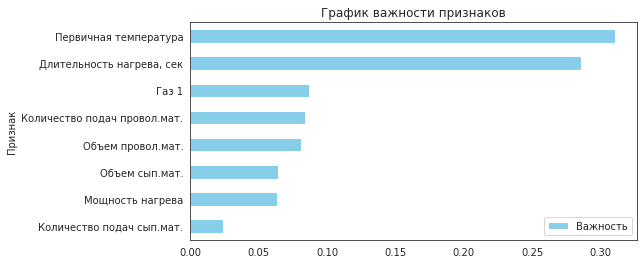

In [45]:
# строим график важности признаков по величине коэффициентов
coefficients = randomized_search.best_estimator_.named_steps['models'].feature_importances_
sns.set_style('white')
feature_importance = pd.DataFrame({'Признак': X_test.columns, 'Важность': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Важность', ascending=True)
feature_importance.plot(x='Признак', y='Важность', kind='barh', figsize=(8, 4), title='График важности признаков', color = 'skyblue'); 

График важности признаков наглядно показывает, что наибольшее влияние имеет признак "Первичная температура", а также сильное влияние оказывает признак длительности нагрева в секундах.

Посмотрим на вклад признаков в решения модели при помощи метода SHAP.

 94%|=================== | 548/581 [00:11<00:00]       

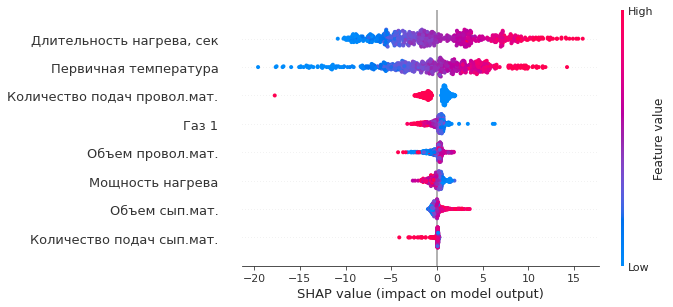

In [46]:
X = pd.DataFrame(randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test), 
                 columns = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out())
best_model = randomized_search.best_estimator_.named_steps['models']
explainer = shap.Explainer(best_model, X)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values) 

График показывает, что чем выше первичная температура и длительность нагрева, тем выше итоговая температура, в меньшей степени, но также увеличивают итоговую температуру объемы материалов. Объем газа для продува, количество подач материалов и мощность нагрева, наоборот, снижают итоговую температуру, но незначительно.

Таким образом, помимо увеличения длительности нагрева, уменьшение количества подач материалов при увеличении их объема в 1 подаче также будет способствовать более быстрому нагреву сплава до необходимой температуры.

### Анализ остатков

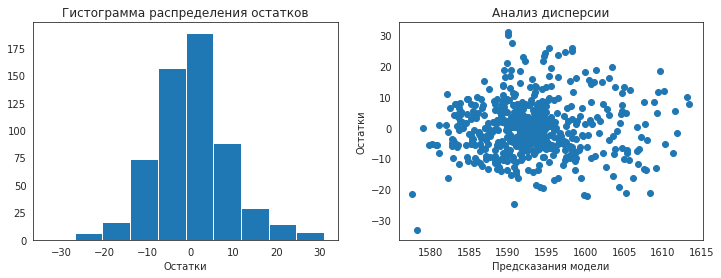

In [47]:
# рассчитаем остатки:
residuals = y_test - predictions
# построим гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Гистограмма распределения остатков показывает относительно равномерное распределение, что говорит о том, что у модели стабильная ошибка на предсказаниях. Анализ дисперсии указывает на увеличение разброса ошибки при предсказании более высоких температур (от 1600), что связано с малым количеством таких признаков в предоставленных данных и, как следствие, модель недообучилась предсказывать подобные значения температур.

## Общий вывод и рекомендации заказчику

***Исходные данные***, предоставленные для моделирования, состоят из 7 файлов разной наполненности с общим признаком, соответствующим номеру партии сплава. Из данных исходных файлов сгенерирован новый датасет, в который включены партии, сведения по которым содержатся в каждом из 7 файлов, а также отобраны подходящие признаки или сгенерированы новые на основе предоставленных. Удалены пропуски в данных и партии, содержащие только 1 измерение температуры сплава (т.к. в них отсутствует целевой признак). Таким образом, сформирован для дальнейшего анализа датасет, состоящий из 10 признаков по 2329 партиям (исходные файлы содержали информацию по 3129-3239): первичная температура, длительность нагрева в секундах, количество нагревов, мощность нагрева, объем сыпучих материалов, количество подач сыпучих материалов, объем проволочных материалов, количество подач проволочных материалов, объема газа для продува. Также выделен целевой признак - итоговая температура.

***Статистический и графический анализы*** данных объединенного датасета показал, что:
- первичная температура принимает значения от 1191 от 1660, медианные значения равны 1587-1593 и схожи со средними, присутствуют выбросы;
- длительность нагрева в секундах принимает значения от 0.95 до 69.82 секунд с медианным значением = 12.97 секунд и средним значением = 13.46 сек., присутствуют аномальные значения;
- количество нагревов принимает значения от 1 до 16 с медианным знначением = 5 и средним значением = 4.7, присутствуют аномальные значения; 
- мощность нагрева принимает значения от 0.33 до 717.94 с медианным значением = 3.77 и средним значением = 4.19, присутствуют аномальные значения и выброс;
- объем сыпучих материалов принимает значения от 19 до 3235 с медианным значением = 609 и схожим средним значением, присутствуют аномальные значения;
- количество подач сыпучих материалов принимает значения от 2 до 8 с медианным значением = 5 и схожим средним значением, аномалии не наблюдаются;  
- объем проволочных материалов принимает значения 1.92 до 568.78 с медианным значением = 116.10 и средним значением = 125.21, присутствуют аномальные значения;
- количество подач проволочных материалов принимает значения от 2 до 6 с медианным знначением = 2 и схожим средним значением = 2.4, аномалии не наблюдаются; 
- объема газа для продува принимает значения от 0.01 до 78 с медианным знначением = 10.1 и средним значением = 11.4, присутствуют аномальные значения.

В ходе статистического и графического анализа выявлены 4 выброса в значениях температур (ниже температуры плавления стали) и 1 выброс в значениях мощности нагрева (значение, более чем в 100 раз превышающее средний показатель), которые были удалены из дальнешего анализа.

***Корреляционный анализ*** признаков выявил мультиколлинеарность входных признаков "Количество нагревов" и "Мощность нагрева", в результате чего из дальнейшего анализа удален признак с наименьшей корреляцией с целевым признаком - "Количество нагревов". Также корреляционный анализ показал высокую связь целевого признака "Итоговая температура" с входным признаком  "Количество подач проволочного материала", умеренную связь с признаками "Мощность нагрева" и "Первичная температура", но слабую связь с признаками "Количество подач сыпучих материалов" и "Объем сыпучих материалов".  

**Цель проекта** - разработка модели, предсказывающую температуру сплава, для оптимизации производственных расходов посредством уменьшения потребления электроэнергии на этапе обработки стали.

Для ***определения лучшей модели машинного обучения*** проведено обучение 5 моделей регрессии и ансамблей моделей (модель линейной регрессии, модель Ridge, модель дерева регрессии, регрессия случайного леса и CatBoostRegressor). Лучшие результаты показала ***регрессия случайного леса*** с глубиной, равной 15, максимальным количеством для деления, равным 77, и количестовм оценщиков, равным 250. Метрика качества модели (средняя абсолютная ошибка) на обучающих данных = 6.71, на тестовых = 6.64.

***Анализ важности признаков*** лучшей модели показал, что на решение модели наибольшее влияние оказали признаки первичной температуры и длительности нагрева в секундах: чем выше первичная температура и длительность нагрева, тем выше итоговая температура. В меньшей степени, но также увеличивают итоговую температуру и объемы материалов. Объем газа для продува, количество подач материалов и мощность нагрева, наоборот, снижают итоговую температуру, хоть и незначительно.

***Анализ остатков*** показал относительно равномерное распределение, то есть стабильность ошибок на предсказаниях. При анализе дисперсии обнаружено увеличение разброса ошибки при предсказании более высоких температур (от 1600), что связано с малым количеством таких признаков в предоставленных данных и, как следствие, модель недообучена предсказывать подобные значения температур.

**Рекомендации**:

1. Улучшить заполняемость данных в связи с наличием большого количеста пропусков в значениях, в том числе и целевого признака - температуры сплава.
2. Провести дополнительную проверку модели на новых качественно собранных данных. 
3. В случае подтверждения качества модели использовать обученую модель регрессии случайного леса для прогнозировнания температуры сплава в целях оптимизации производственных расходов посредством уменьшения потребления электроэнергии на этапе обработки стали.
4. Рассмотреть возможность увеличения длительности нагрева для более быстрого достижения необходимой температуры сплава.
5. Рассмотреть возможность уменьшения количества подач материалов при увеличении их объема в 1 подаче, что также будет способствовать более быстрому нагреву сплава до необходимой температуры и снижению износа оборудования.
6. В случае появления новых признаков (например, границы допустимых температур) либо существенных изменений в данных текущих признаков обратиться за обновлением модели машинного обучения, предсказывающей температуру сплава, в том числе, при необходимости предсказания высоких температур (от 1600).